This notebook addresses the following research question and hypotheses:

* __RQ3__: How does the evolution of performance in the task link to the learning outcomes?
    * __H3.1__: The more a participant’s submissions improve, the better are the learning outcomes.
    * __H3.2__: The more a participant’s suggestions improve, the better are the learning outcomes.
    * __H3.3__: The more a participant’s (dis)agreements improve, the better are the learning outcomes.

## Initialization

In [1]:
import pickle

import pathlib as pl
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter, AutoMinorLocator
import seaborn as sns
import numpy as np

from scipy.stats import wilcoxon, shapiro, spearmanr, pearsonr, linregress
from effsize.effsize import two_group_difference

from utils import plot_comparison, pick_colors

from justhink_world.domain.action import *

In [3]:
rc = {
    'ps.useafm': True,
    'pdf.use14corefonts': True,  # Switch to Type 1 Fonts.
    'text.usetex': True,
    'figure.dpi': 300,
    'savefig.dpi': 300,
}
sns.set_theme('paper', style='whitegrid', font_scale=2.5, rc=rc)

In [4]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

### Define paths.

In [6]:
# Inputs.
learning_file = pl.Path(
    '../processed_data/justhink21_learning_outcomes.csv')
performance_file = pl.Path(
    '../processed_data/justhink21_task_performance.csv')

transitions_pickle_file = pl.Path(
    '../processed_data/justhink21_transitions_annotated.pickle')

# Outputs.
figs_dir = pl.Path('../figures')
perf_vs_learning_fig_file = figs_dir.joinpath('performance_vs_learning.pdf')
change_fig_file = figs_dir.joinpath('change_performance.pdf')

### Load learning outcomes table.

In [7]:
learning_df = pd.read_csv(learning_file, index_col=0)
cols = ['pretest_errors', 'posttest_errors']

for c in cols:
    new_values_list = list()
    for values in learning_df[c]:
        values = eval(values.replace('nan', 'np.NaN'))
        new_values_list.append(values)
    learning_df[c] = new_values_list
    
learning_df

,pretest_feasible,posttest_feasible,pretest_optimal,posttest_optimal,pretest_error,posttest_error,pretest_errors,posttest_errors,gain_feasible,gain_optimal,learning_gain
participant,,,,,,,,,,,
1,1.0,1.0,0.4,0.8,0.169524,0.013333,"[0.5333333333333333, 0.26666666666666666, 0.04...","[0.0, 0.0, 0.0, 0.0, 0.06666666666666667]",0.0,0.666667,0.156190
2,0.8,1.0,0.0,0.8,0.310476,0.009524,"[nan, 0.6, 0.2857142857142857, 0.2, 0.46666666...","[0.0, 0.0, 0.047619047619047616, 0.0, 0.0]",1.0,0.800000,0.300952
3,1.0,1.0,0.2,1.0,0.040635,0.000000,"[0.06666666666666667, 0.06666666666666667, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.0,1.000000,0.040635
4,0.8,1.0,0.0,0.0,0.389841,0.355556,"[nan, 1.2666666666666666, 0.23809523809523808,...","[0.2, 0.4, 0.3333333333333333, 0.5111111111111...",1.0,NaN,0.034286
5,1.0,0.8,0.0,0.0,0.300317,0.166984,"[0.4666666666666667, 0.26666666666666666, 0.19...","[0.26666666666666666, nan, 0.19047619047619047...",-0.2,NaN,0.133333
6,1.0,0.8,0.0,0.0,0.309841,0.149841,"[0.26666666666666666, 0.5333333333333333, 0.23...","[nan, 0.26666666666666666, 0.23809523809523808...",-0.2,NaN,0.160000
7,0.4,0.0,0.2,0.0,0.040000,NaN,"[0.2, 0.0, nan, nan, nan]","[nan, nan, nan, nan, nan]",-1.0,-1.000000,NaN
8,1.0,1.0,0.0,0.0,0.925714,0.103492,"[0.2, 1.6, 1.4285714285714286, 1.2, 0.2]","[0.13333333333333333, 0.2, 0.09523809523809523...",0.0,NaN,0.822222
9,1.0,1.0,0.8,0.8,0.013333,0.009524,"[0.06666666666666667, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.047619047619047616, 0.0, 0.0]",0.0,0.000000,0.003810


### Load the task performance table.

In [8]:
performance_df = pd.read_csv(performance_file, index_col=0)
performance_df

,attempt_no_1,attempt_no_2,error_1,error_2,is_mst_1,is_mst_2,is_spanning_1,is_spanning_2,performance_gain
participant,,,,,,,,,
1,2.0,3.0,0.318182,0.000000,False,True,True,True,0.318182
2,1.0,3.0,0.000000,0.000000,True,True,True,True,-0.000000
3,3.0,2.0,0.000000,0.057143,True,False,True,True,-0.057143
4,2.0,3.0,0.318182,0.000000,False,True,True,True,0.318182
5,3.0,1.0,0.318182,0.000000,False,True,True,True,0.318182
6,1.0,1.0,0.772727,0.542857,False,False,True,True,0.229870
7,2.0,NaN,0.000000,NaN,True,NaN,True,NaN,NaN
8,3.0,2.0,0.045455,0.000000,False,True,True,True,0.045455
9,1.0,1.0,0.000000,0.000000,True,True,True,True,-0.000000


### Load transition tables.

In [9]:
with transitions_pickle_file.open('rb') as handle:
    transitions_df = pickle.load(handle)

### Combine to a results summary table.

In [10]:
results_df = pd.concat([performance_df, learning_df], axis=1)
results_df

,attempt_no_1,attempt_no_2,error_1,error_2,is_mst_1,is_mst_2,is_spanning_1,is_spanning_2,performance_gain,pretest_feasible,posttest_feasible,pretest_optimal,posttest_optimal,pretest_error,posttest_error,pretest_errors,posttest_errors,gain_feasible,gain_optimal,learning_gain
participant,,,,,,,,,,,,,,,,,,,,
1,2.0,3.0,0.318182,0.000000,False,True,True,True,0.318182,1.0,1.0,0.4,0.8,0.169524,0.013333,"[0.5333333333333333, 0.26666666666666666, 0.04...","[0.0, 0.0, 0.0, 0.0, 0.06666666666666667]",0.0,0.666667,0.156190
2,1.0,3.0,0.000000,0.000000,True,True,True,True,-0.000000,0.8,1.0,0.0,0.8,0.310476,0.009524,"[nan, 0.6, 0.2857142857142857, 0.2, 0.46666666...","[0.0, 0.0, 0.047619047619047616, 0.0, 0.0]",1.0,0.800000,0.300952
3,3.0,2.0,0.000000,0.057143,True,False,True,True,-0.057143,1.0,1.0,0.2,1.0,0.040635,0.000000,"[0.06666666666666667, 0.06666666666666667, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.0,1.000000,0.040635
4,2.0,3.0,0.318182,0.000000,False,True,True,True,0.318182,0.8,1.0,0.0,0.0,0.389841,0.355556,"[nan, 1.2666666666666666, 0.23809523809523808,...","[0.2, 0.4, 0.3333333333333333, 0.5111111111111...",1.0,NaN,0.034286
5,3.0,1.0,0.318182,0.000000,False,True,True,True,0.318182,1.0,0.8,0.0,0.0,0.300317,0.166984,"[0.4666666666666667, 0.26666666666666666, 0.19...","[0.26666666666666666, nan, 0.19047619047619047...",-0.2,NaN,0.133333
6,1.0,1.0,0.772727,0.542857,False,False,True,True,0.229870,1.0,0.8,0.0,0.0,0.309841,0.149841,"[0.26666666666666666, 0.5333333333333333, 0.23...","[nan, 0.26666666666666666, 0.23809523809523808...",-0.2,NaN,0.160000
7,2.0,NaN,0.000000,NaN,True,NaN,True,NaN,NaN,0.4,0.0,0.2,0.0,0.040000,NaN,"[0.2, 0.0, nan, nan, nan]","[nan, nan, nan, nan, nan]",-1.0,-1.000000,NaN
8,3.0,2.0,0.045455,0.000000,False,True,True,True,0.045455,1.0,1.0,0.0,0.0,0.925714,0.103492,"[0.2, 1.6, 1.4285714285714286, 1.2, 0.2]","[0.13333333333333333, 0.2, 0.09523809523809523...",0.0,NaN,0.822222
9,1.0,1.0,0.000000,0.000000,True,True,True,True,-0.000000,1.0,1.0,0.8,0.8,0.013333,0.009524,"[0.06666666666666667, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.047619047619047616, 0.0, 0.0]",0.0,0.000000,0.003810


## Processing

In [11]:
collab_activities = ['collaboration-1', 'collaboration-2']

### Annotate optimality score for the actions.

In [12]:
transitions_df['optimality_score'] = \
    [1 if row['is_optimal'] else 0 for i, row in transitions_df.iterrows()]

### Annotate the trend of improvement for the actions.

In [13]:
actions = {
    'suggest': [SuggestPickAction],
    'agree': [AgreeAction],
    'disagree': [DisagreeAction],
    '(dis)agree': [AgreeAction, DisagreeAction],
    'all': None,
}

In [14]:
# Suppress the constant array warnings by SciPy.
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [15]:
for action_name, action_types in actions.items():
    print(action_name)
    for activity in collab_activities:
        slopes = list()
        slope_pvalues = list()
        correlations = list()
        corr_pvalues = list()
        counts = list()

        for participant in results_df.index:
            activity_index = activity.split('-')[-1]
            df = transitions_df.copy()

            df = df[df.participant.isin([participant])]
            df = df[df.activity.isin([activity])]
            df = df[df.is_human]
            if action_types is not None:
                df = df[[
                    np.array([isinstance(a, action_type)
                             for action_type in action_types]).sum() > 0
                        for a in df['action']]]

            xcol = 'time_in_activity_frac'
            ycol = 'optimality_score'

            x = df[xcol].tolist()
            y = df[ycol].tolist()

            result = linregress(x, y)
            slopes.append(result.slope)
            slope_pvalues.append(result.pvalue)

            r, p = pearsonr(x, y)
            correlations.append(r)
            corr_pvalues.append(p)

            counts.append(len(x))

            print(participant, len(x), activity, result.slope, result.pvalue)

        results_df['{}_slope_{}'.format(
            action_name, activity_index)] = slopes
        results_df['{}_slope_{}_count'.format(
            action_name, activity_index)] = counts
        results_df['{}_slope_p_{}'.format(
            action_name, activity_index)] = slope_pvalues
        results_df['{}_corr_{}'.format(
            action_name, activity_index)] = correlations
        results_df['{}_corr_p_{}'.format(
            action_name, activity_index)] = corr_pvalues

    print()

suggest
1 26 collaboration-1 0.20828615275888046 0.5548796951808848
2 14 collaboration-1 0.838486873089991 0.08292273269910326
3 21 collaboration-1 0.2972557307253791 0.4363131889713725
4 34 collaboration-1 0.32420551330615865 0.28479618966764475
5 34 collaboration-1 -0.018038942106735716 0.950591920447794
6 24 collaboration-1 -0.5334487300233023 0.14045454621576717
7 11 collaboration-1 0.0 1.0
8 33 collaboration-1 -0.651101215793054 0.034843300009212215
9 8 collaboration-1 0.0 1.0
1 23 collaboration-2 0.2479265683006108 0.48321004640910536
2 13 collaboration-2 1.4050944329469766 1.4741736534228772e-06
3 25 collaboration-2 -1.055477126932943 0.0009380456869270954
4 18 collaboration-2 0.2999800073919115 0.2738508331811356
5 9 collaboration-2 0.0 1.0
6 22 collaboration-2 0.20945693251031317 0.5809122750391369
7 21 collaboration-2 -0.27358288203198783 0.3641628694477893
8 13 collaboration-2 0.451646183014227 0.3096411942308179
9 6 collaboration-2 0.0 1.0

agree
1 24 collaboration-1 0.0654

## Hypothesis Testing

### H3.1: The more the learner improves his/her submissions, the better are the learning outcomes.

#### Check performance gain vs. learning gain.
How does error difference (collab activities) correlate with learning gain (tests)?

In [16]:
cols = ['performance_gain', 'learning_gain']
df = results_df.dropna(subset=cols)
pearsonr(list(df[cols[0]]), list(df[cols[1]])), len(df)

(PearsonRResult(statistic=-0.21891642993094784, pvalue=0.6024574444863945), 8)

In [17]:
results_df['error_1']

participant
1    0.318182
2    0.000000
3    0.000000
4    0.318182
5    0.318182
6    0.772727
7    0.000000
8    0.045455
9    0.000000
Name: error_1, dtype: float64

In [18]:
cols = ['error_1', 'learning_gain']
df = results_df.dropna(subset=cols)
pearsonr(list(df[cols[0]]), list(df[cols[1]])), len(df)

(PearsonRResult(statistic=-0.20252384034978202, pvalue=0.6305234077787142), 8)

### H3.2: The more the learner improves his/her suggestions, the better are the learning  outcomes.

### H3.3: The more the learner improves his/her (dis)agreements, the better are the learning outcomes.

In [19]:
for action_name, action in actions.items():
    print(action_name)
    for activity in collab_activities:
        activity_index = activity.split('-')[-1]

        c = '{}_slope_{}'.format(action_name, activity_index)
        df = results_df.dropna(subset=[c, 'learning_gain'])
        print('Slope:', activity, len(df), spearmanr(
            df[c].tolist(), df['learning_gain'].tolist()))

        if action_name in ['all', '(dis)agree']:
            print(x)
    print()

suggest
Slope: collaboration-1 8 SpearmanrResult(correlation=-0.30952380952380953, pvalue=0.4556448907375822)
Slope: collaboration-2 8 SpearmanrResult(correlation=0.6347419188140273, pvalue=0.09089043638915878)

agree
Slope: collaboration-1 8 SpearmanrResult(correlation=-0.14285714285714288, pvalue=0.735764859879812)
Slope: collaboration-2 8 SpearmanrResult(correlation=0.6586944440522925, pvalue=0.0756896878416385)

disagree
Slope: collaboration-1 8 SpearmanrResult(correlation=-0.4071929290505081, pvalue=0.31670918491612815)
Slope: collaboration-2 8 SpearmanrResult(correlation=-0.5000000000000001, pvalue=0.20703124999999997)

(dis)agree
Slope: collaboration-1 8 SpearmanrResult(correlation=-0.8333333333333335, pvalue=0.01017554012345675)
[0.011617442224346236, 0.050828835075183376, 0.11831094331723162, 0.19781135953296594, 0.387557588733579, 0.45816126480017483, 0.5925251743349041, 0.6314110687092472, 0.7254540759847117, 0.7628747089075404, 0.8395826659502801, 0.8943187238346945, 0.9657

In [20]:
df = results_df.sort_values('learning_gain')
dff = df[['learning_gain', 
    'agree_slope_1', 'agree_slope_1_count', 
    'disagree_slope_1', 'disagree_slope_1_count', 
    '(dis)agree_slope_1', '(dis)agree_slope_1_count']
  ]

display(dff)

dff.describe()

,learning_gain,agree_slope_1,agree_slope_1_count,disagree_slope_1,disagree_slope_1_count,(dis)agree_slope_1,(dis)agree_slope_1_count
participant,,,,,,,
9,0.003810,0.000000,2,1.276819,7,1.468461,9
4,0.034286,0.046631,22,0.550826,14,0.360407,36
3,0.040635,0.045090,19,0.000000,3,0.093757,22
5,0.133333,-0.536085,16,-0.339566,18,-0.164145,34
1,0.156190,0.065429,24,0.000000,2,-0.008079,26
6,0.160000,-0.240979,17,-0.109026,9,-0.223329,26
2,0.300952,0.772735,9,-1.910923,6,0.052144,15
8,0.822222,-0.724596,29,1.080211,6,-0.541305,35
7,NaN,0.000000,6,0.708774,6,0.108196,12


,learning_gain,agree_slope_1,agree_slope_1_count,disagree_slope_1,disagree_slope_1_count,(dis)agree_slope_1,(dis)agree_slope_1_count
count,8.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,0.206429,-0.063531,16.000000,0.139679,7.888889,0.127345,23.888889
std,0.266280,0.424232,8.831761,0.949086,5.134307,0.562742,10.166667
min,0.003810,-0.724596,2.000000,-1.910923,2.000000,-0.541305,9.000000
25%,0.039048,-0.240979,9.000000,-0.109026,6.000000,-0.164145,15.000000
50%,0.144762,0.000000,17.000000,0.000000,6.000000,0.052144,26.000000
75%,0.195238,0.046631,22.000000,0.708774,9.000000,0.108196,34.000000
max,0.822222,0.772735,29.000000,1.276819,18.000000,1.468461,36.000000


## Visualizations

### Visualize performance vs. learning gains.

Graph is exported to ../figures/performance_vs_learning.pdf


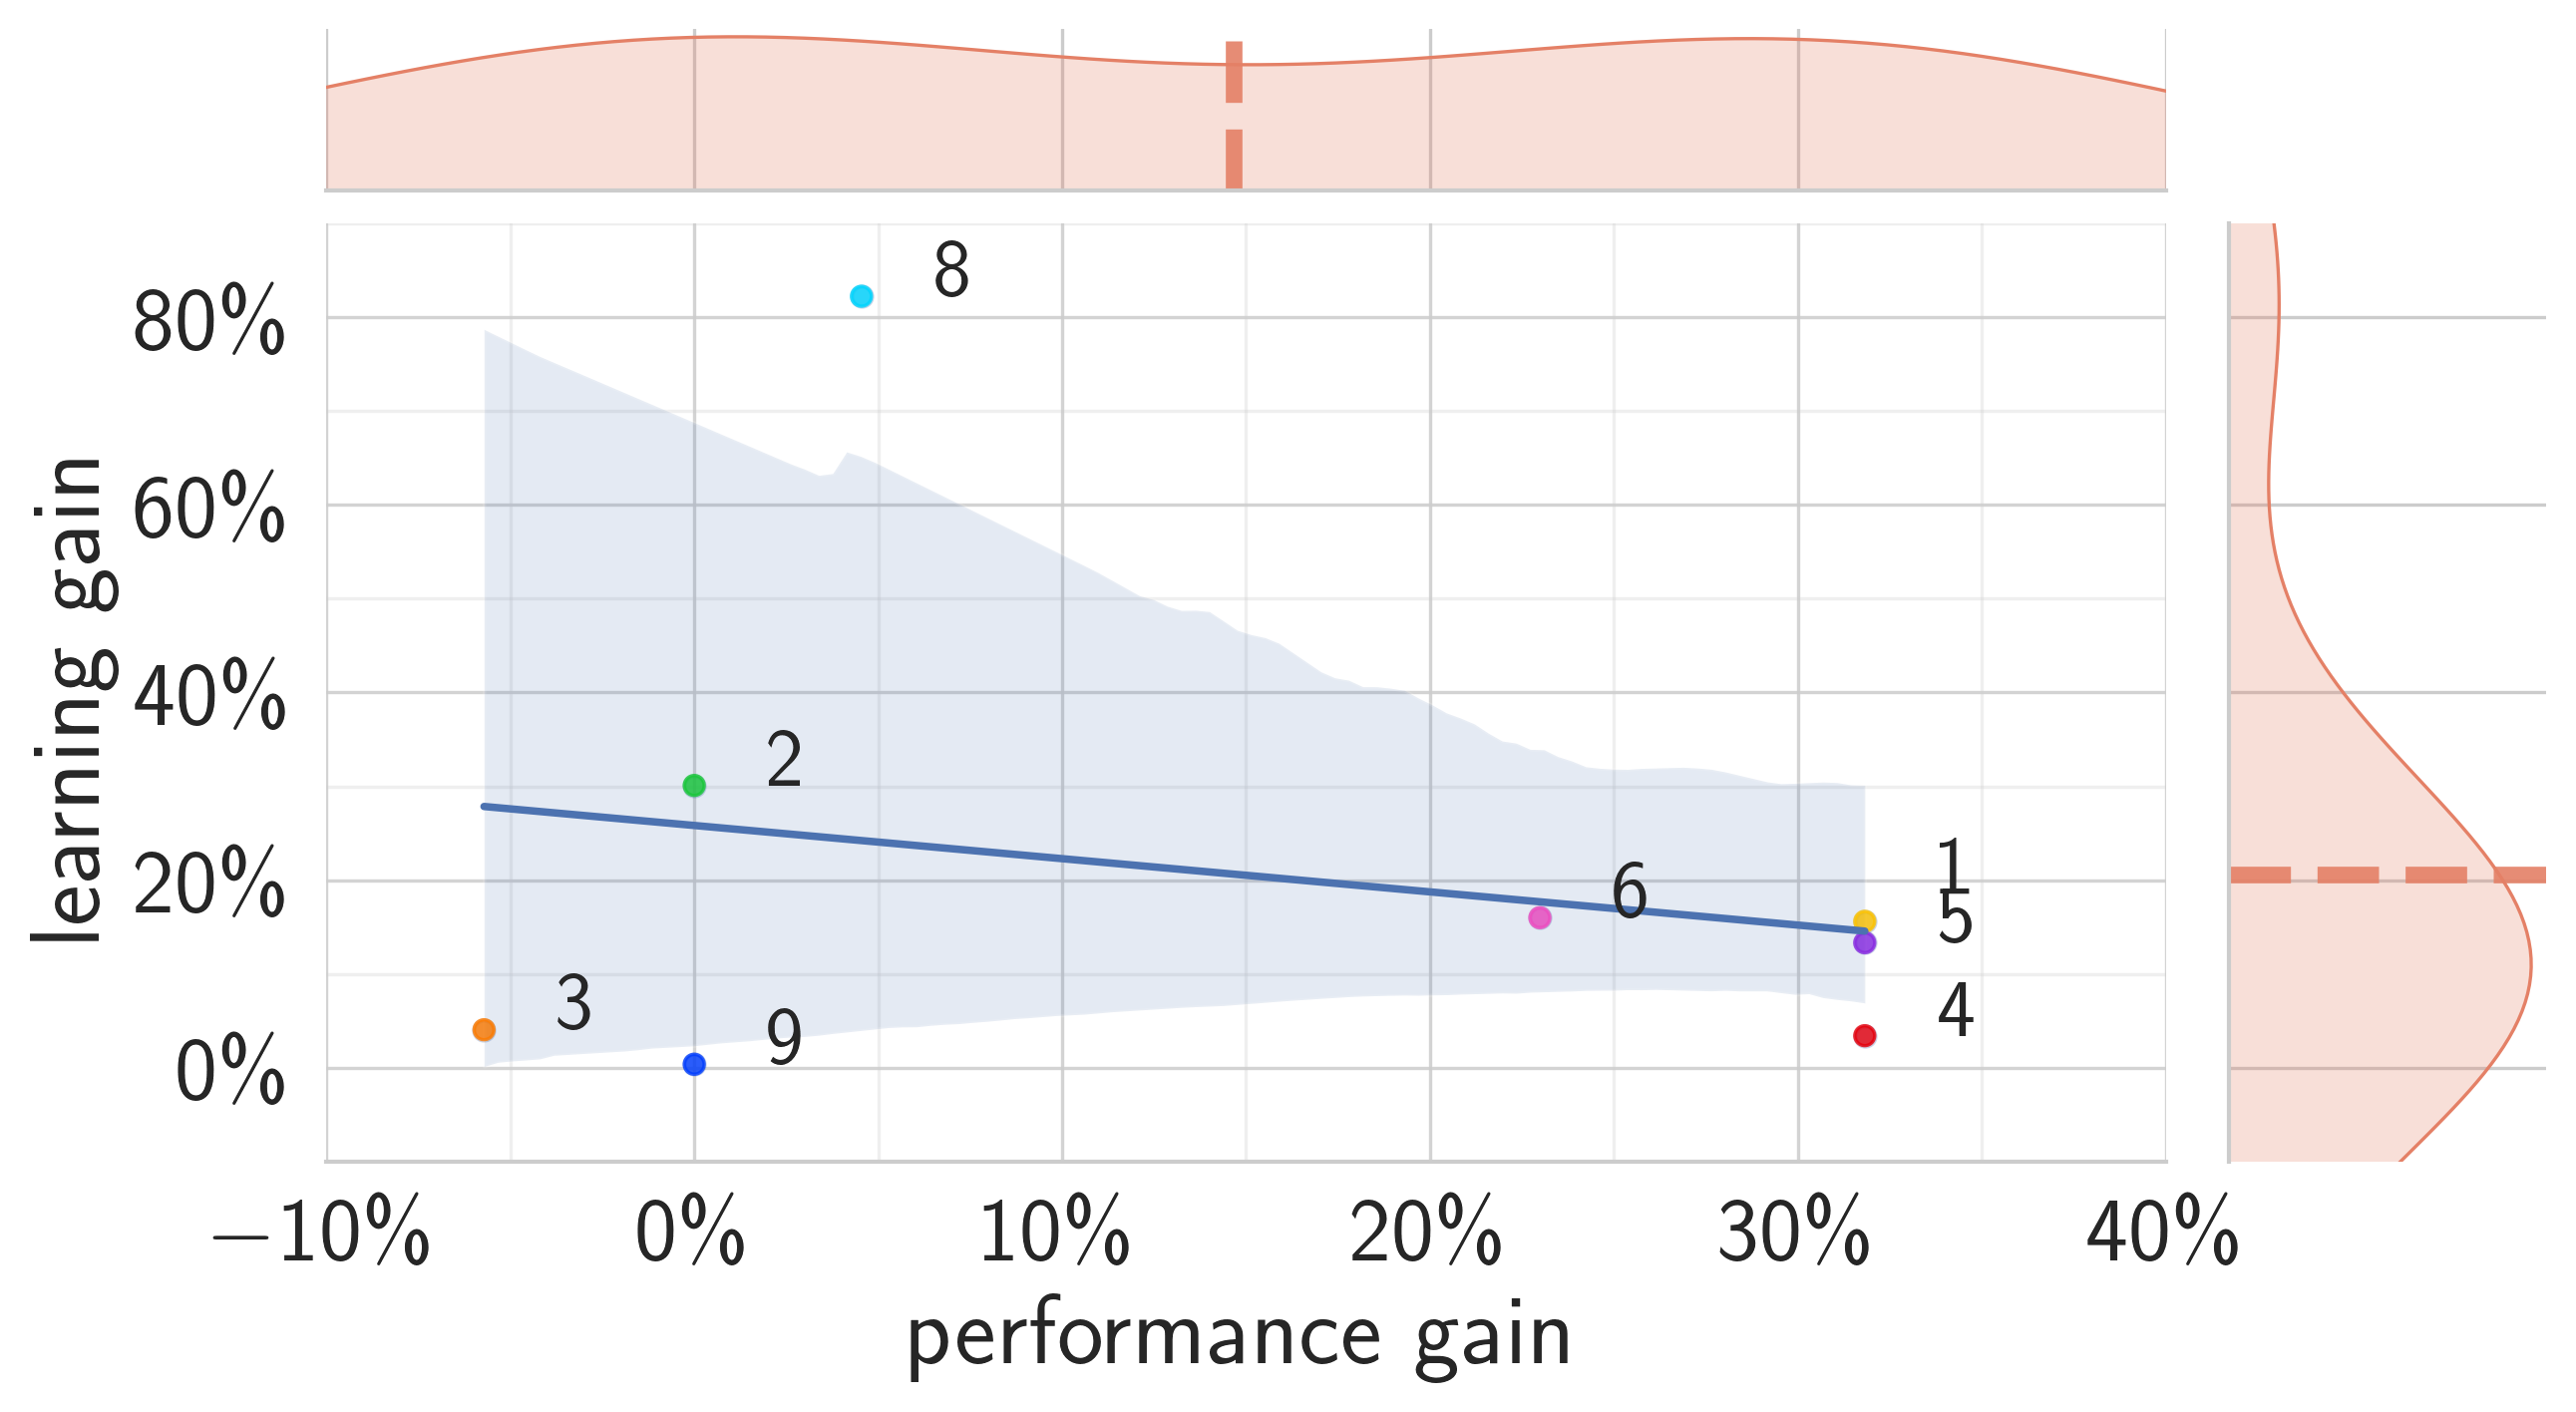

In [21]:
def plot_performance_vs_learning(
        col_x, col_y, df, colors, scatter_alpha=.8):

    def colored_scatter(x, y, c=None, label=None):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
            kwargs['alpha'] = scatter_alpha
            kwargs['label'] = label
            plt.scatter(*args, **kwargs)

        return scatter

    df = df.copy()
    prev_x_counts = None
    prev_y_counts = None

    step = 10
    g = sns.JointGrid(
        x=col_x, y=col_y, xlim=[-0.1, 0.4], ylim=[-0.1, 0.9], data=df)

    g.fig.set_figwidth(10)
    g.fig.set_figheight(5)

    sns.despine(ax=g.ax_joint, left=True)

    # Plot versus.
    sns.regplot(
        x=col_x, y=col_y, data=df, ax=g.ax_joint,
        scatter_kws={'alpha': 0.3})

    g.plot_joint(colored_scatter(df[col_x], df[col_y], colors))

    # Plot performance distribution.
    # Draw a KDE plot.
    color = '#e48066'
    sns.kdeplot(
        df[col_x].values, ax=g.ax_marg_x, color=color, shade=True)
    # Draw the mean line segments.
    m = np.mean(df[col_x])
    g.ax_marg_x.axvline(
        m, ls='--', lw=4, c=color, alpha=0.9)

    # Plot learning distribution.
    # Draw a KDE plot.
    sns.kdeplot(
        y=df[col_y].values, ax=g.ax_marg_y, color=color, shade=True,
    )
    # Draw the mean line segments.
    m = np.mean(df[col_y])
    g.ax_marg_y.axhline(
        m, ls='--', lw=4, c=color, alpha=0.9)

    # Adjust the ticks.
    g.ax_joint.xaxis.set_minor_locator(AutoMinorLocator(n=2))
    g.ax_joint.yaxis.set_minor_locator(AutoMinorLocator(n=2))

    # Adjust the grid.
    plt.grid(alpha=0.85)
    plt.grid(which='minor', alpha=0.3)

    # Adjust the background colors.
    g.ax_marg_x.set_facecolor('white')
    g.ax_marg_y.set_facecolor('white')

    # Add annotations one by one with a loop.
    takens = dict()
    for i, row in df.iterrows():
        x, y = row[col_x], row[col_y]
        if np.isnan(x) or np.isnan(y):
            continue
        offset = (0.02, 0) if i != 1 else (0.02, 0.03)
        g.ax_joint.text(
            x + offset[0], y + offset[1], str(i), fontsize='small')

    g.ax_joint.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    g.ax_joint.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # Set axis labels.
    g.ax_joint.set_xlabel('performance gain')
    g.ax_joint.set_ylabel('learning gain')

    return g


perf_col = 'performance_gain'
learn_col = 'learning_gain'
df = results_df

colors = pick_colors()
colors = [colors[p] for p in df.index]
g = plot_performance_vs_learning(perf_col, learn_col, results_df, colors)

# Export as vector graphics - pdf.
plt.savefig(perf_vs_learning_fig_file, bbox_inches='tight')
print('Graph is exported to {}'.format(perf_vs_learning_fig_file))

### Visualize performance vs. learning changes.

In [22]:
# from https://stackoverflow.com/a/34018322
def add_arrow(line, position=None, direction='right', size=24, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate(
        '',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )

Graph is exported to ../figures/change_performance.pdf


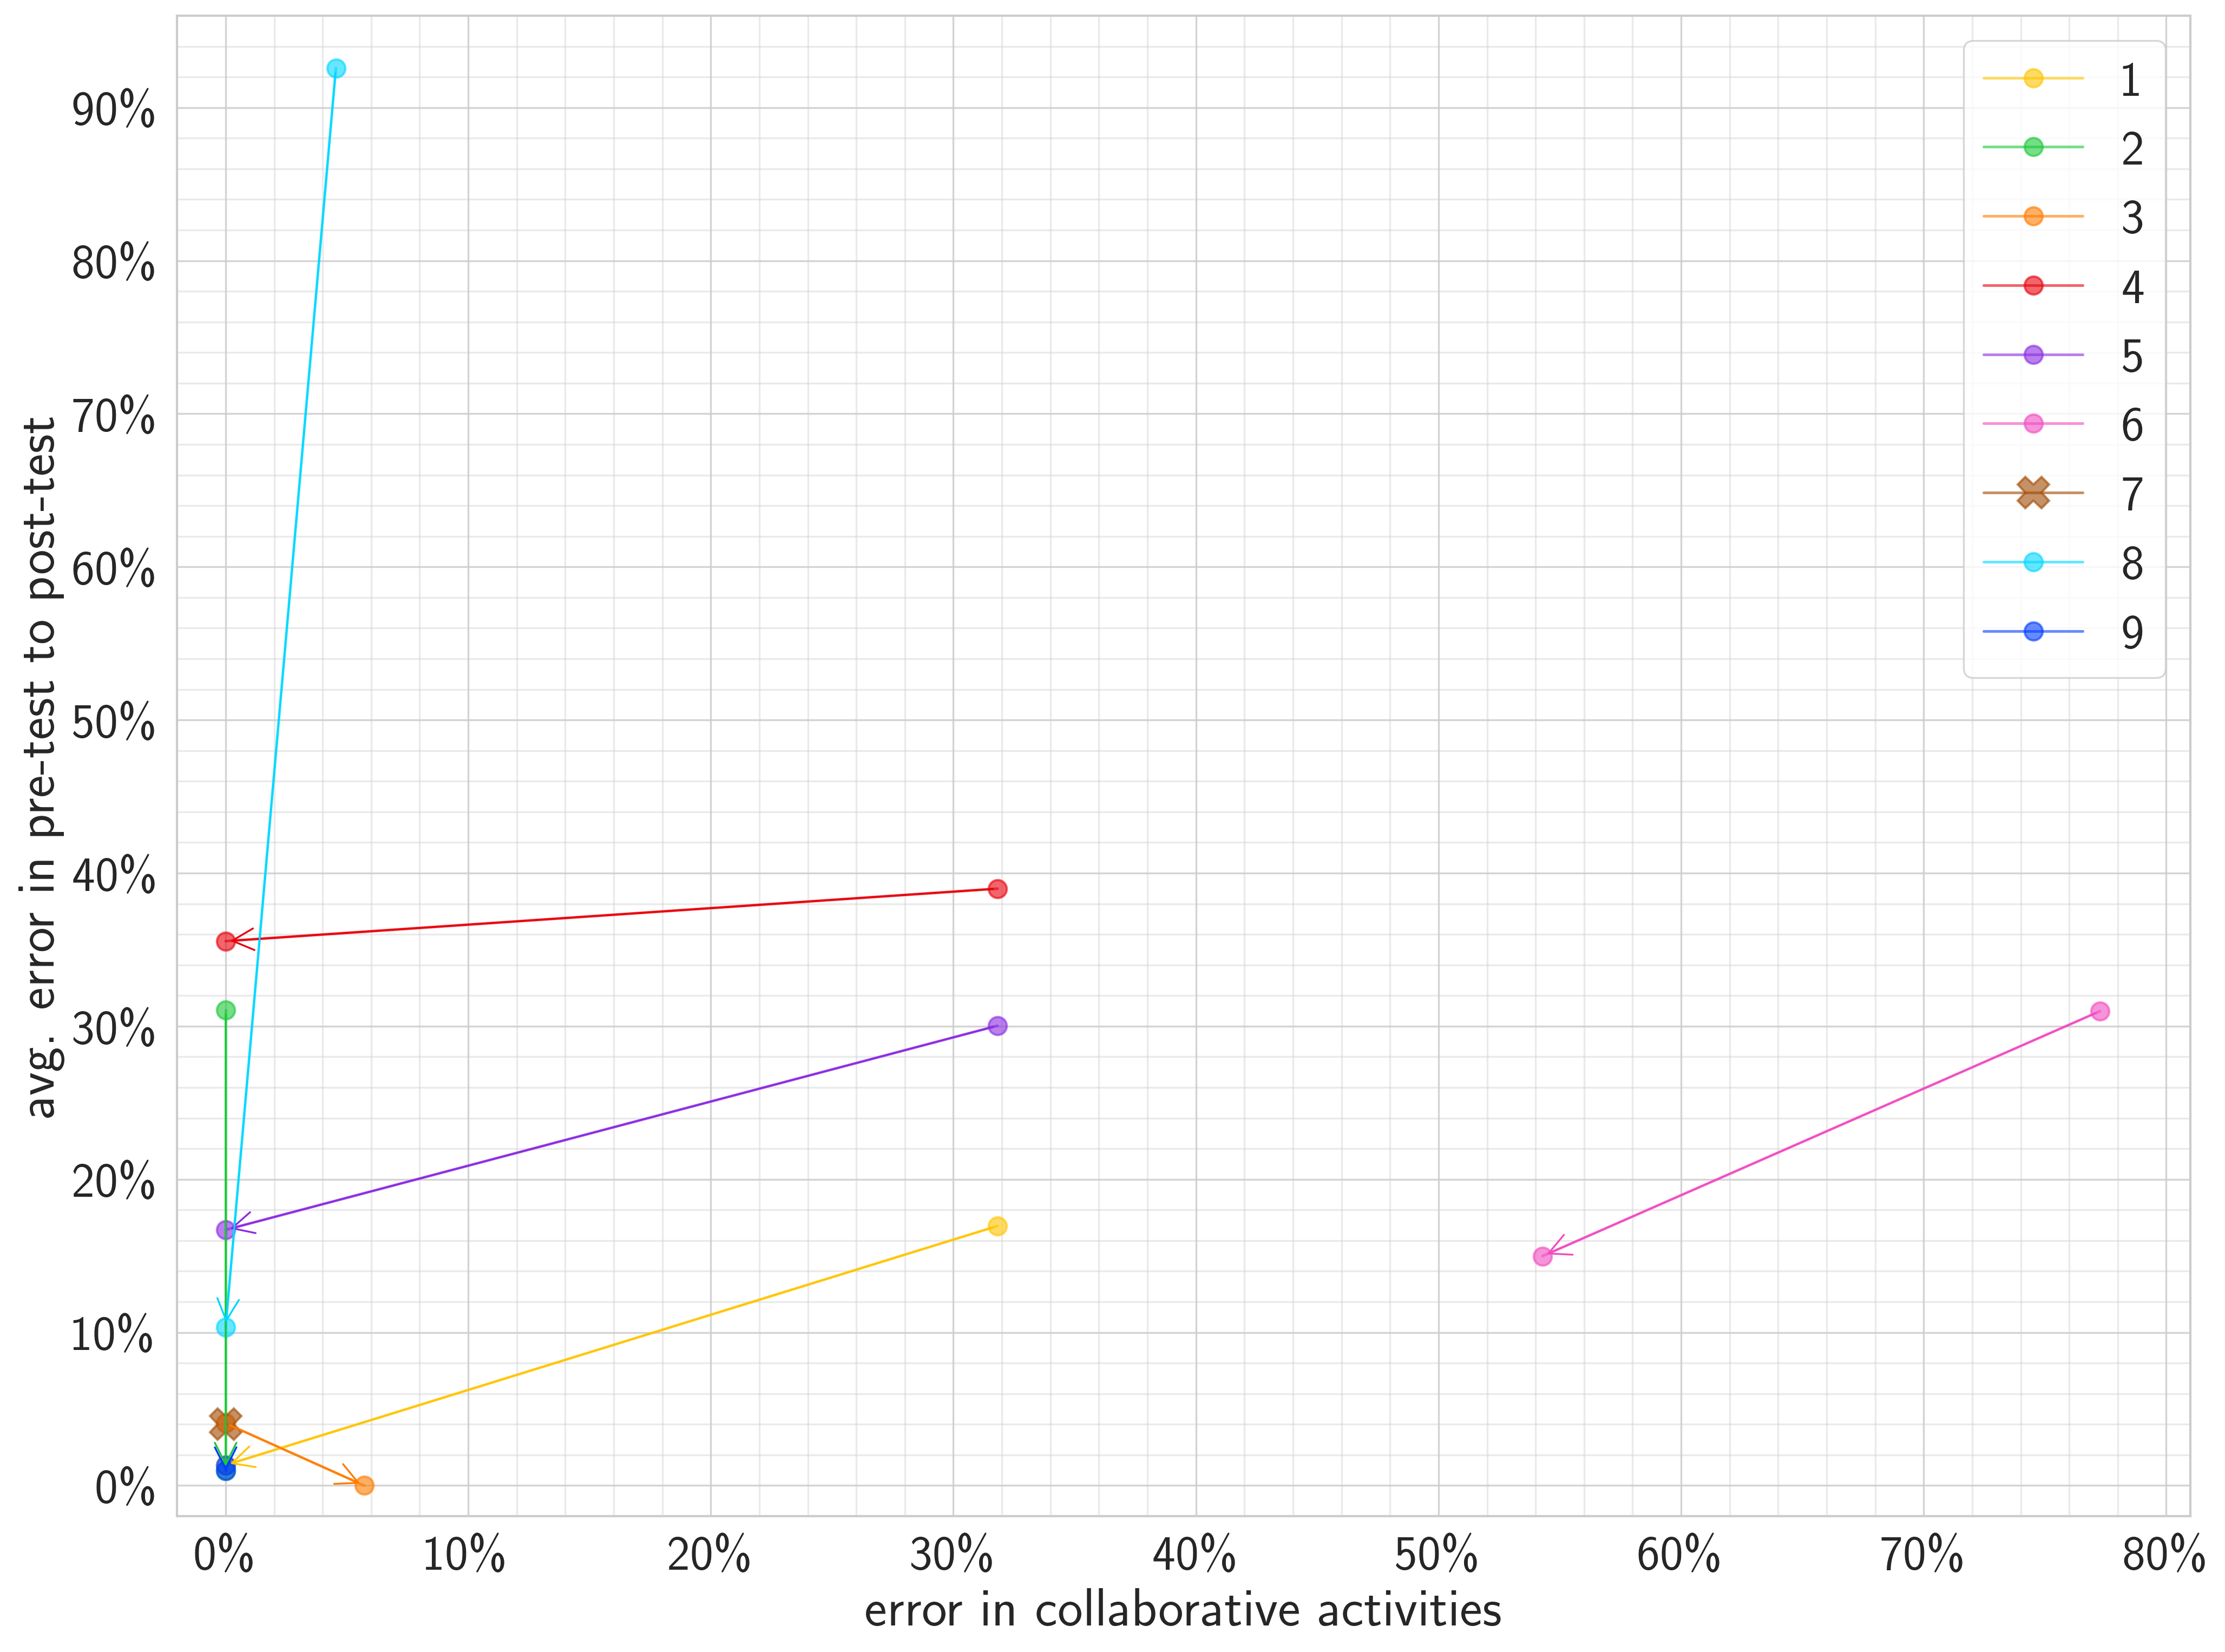

In [23]:
perf_cols = ['error_1', 'error_2']
learn_cols = ['pretest_error', 'posttest_error']
learn_values_cols = ['pretest_errors', 'posttest_errors']
df = results_df
df.columns

colors = pick_colors()

fig, ax = plt.subplots(1, figsize=(16, 12))
for i, row in df.iterrows():
    xs = row[perf_cols[0]], row[perf_cols[1]]
    ys = row[learn_cols[0]], row[learn_cols[1]]

    values = list(xs) + list(ys)
    marker, ms = 'o', 8  # 'D'
    for v in values:
        if np.isnan(v):
            marker, ms = 'X', 14

    line = ax.plot(
        xs, ys, marker=marker, ms=ms,
        color=colors[i], label=i, alpha=.6)[0]
    add_arrow(line)
    
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    ax.set_xlim([-0.02, .81])
    ax.set_ylim([-0.02, .96])
    ax.set_yticks(np.arange(0, .91, .1))

    leg = plt.legend(sorted(df.index), loc='upper right', frameon=True)

    # Adjust the ticks.
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))

    # Adjust the grid.
    plt.grid(alpha=0.85)
    plt.grid(which='minor', alpha=0.4)

    ax.set_xlabel('error in collaborative activities')
    ax.set_ylabel('avg. error in pre-test to post-test')

plt.savefig(change_fig_file, bbox_inches='tight')
print('Graph is exported to {}'.format(change_fig_file))

Graph is exported to ../figures/change_performance.pdf


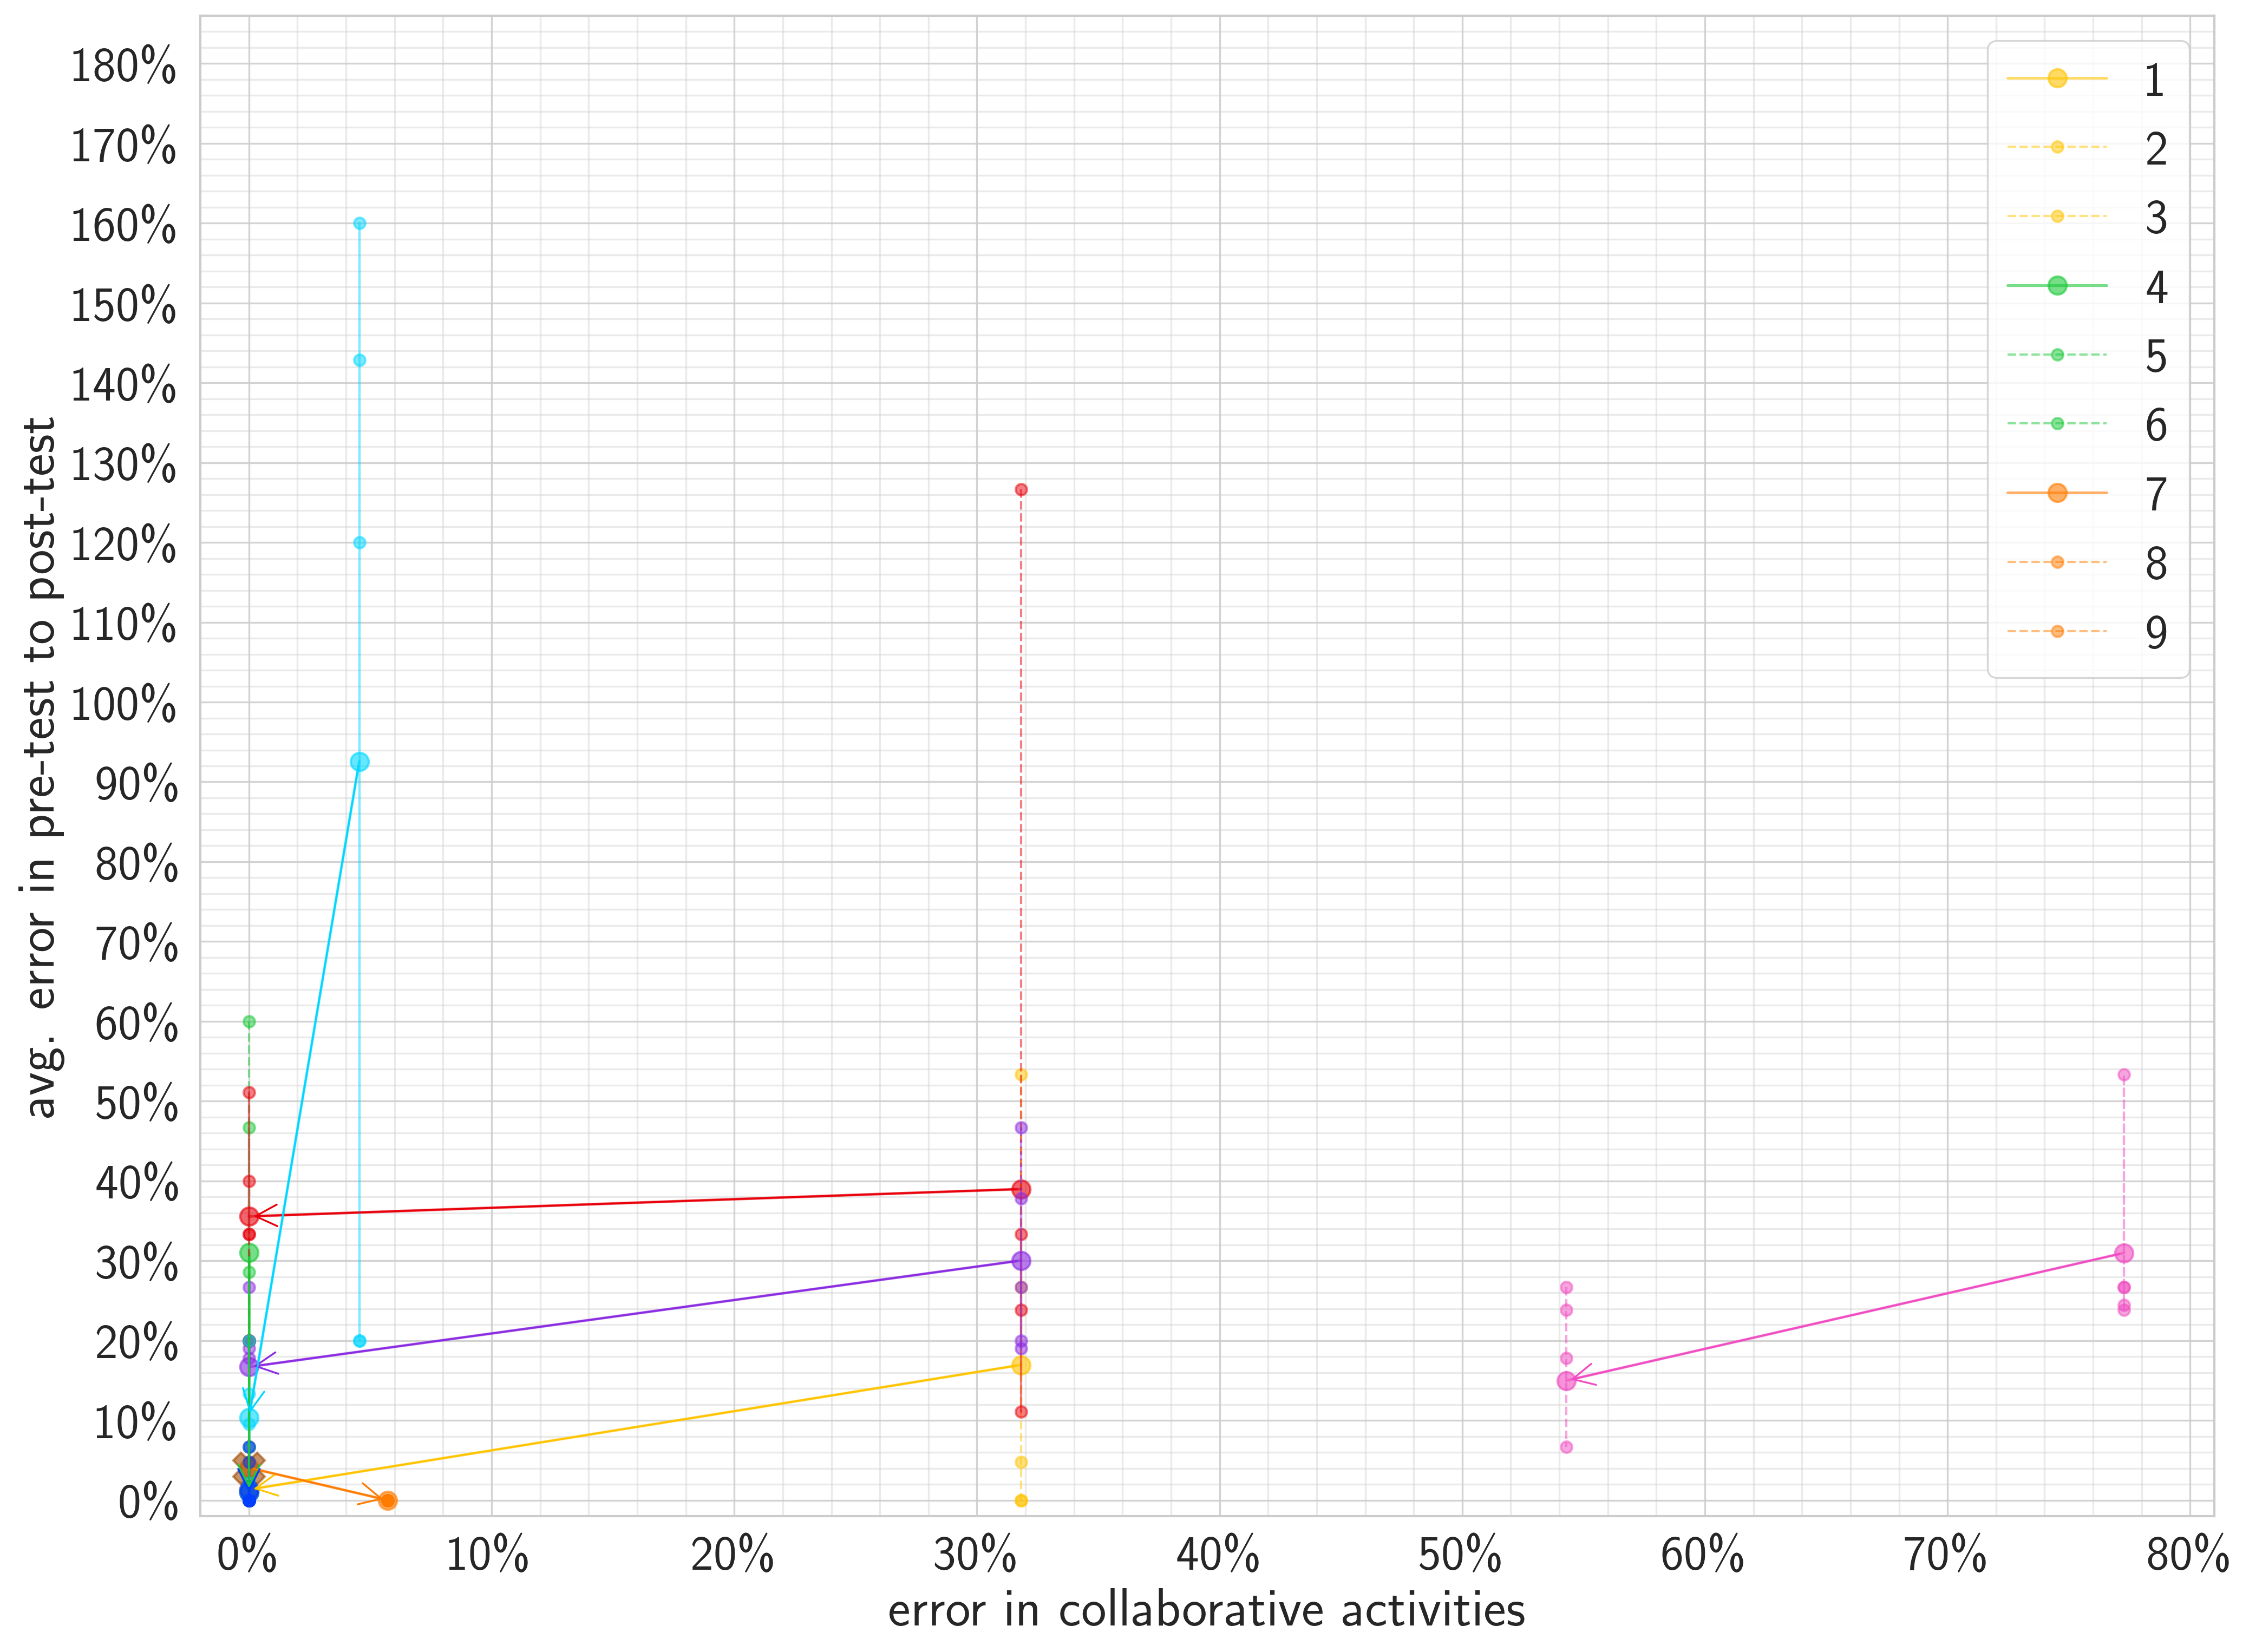

In [24]:
# plot with distributions
perf_cols = ['error_1', 'error_2']
learn_cols = ['pretest_error', 'posttest_error']
learn_values_cols = ['pretest_errors', 'posttest_errors']
df = results_df
df.columns

colors = pick_colors()

fig, ax = plt.subplots(1, figsize=(16, 12))
for i, row in df.iterrows():
    xs = row[perf_cols[0]], row[perf_cols[1]]
    ys = row[learn_cols[0]], row[learn_cols[1]]

    values = list(xs) + list(ys)
    marker, ms = 'o', 8  # 'D'
    for v in values:
        if np.isnan(v):
            marker, ms = 'X', 14

    line = ax.plot(
        xs, ys, marker=marker, ms=ms,
        color=colors[i], label=i, alpha=.6)[0]
    add_arrow(line)

    for j, col in enumerate(learn_values_cols):
        ys = row[col]
        xs = [row[perf_cols[j]] for _ in range(len(ys))]
        marker, ms = '.', 10
        ax.plot(
            xs, ys, '--', marker=marker, ms=ms, color=colors[i], 
            label=i, linewidth=1, alpha=.5)

    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    ax.set_xlim([-0.02, .81])
    # ax.set_ylim([-0.02, .96])
    ax.set_ylim([-0.02, 1.86])
    ax.set_yticks(np.arange(0, 1.861, .1))

    leg = plt.legend(sorted(df.index), loc='upper right', frameon=True)

    # Adjust the ticks.
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))

    # Adjust the grid.
    plt.grid(alpha=0.85)
    plt.grid(which='minor', alpha=0.4)

    ax.set_xlabel('error in collaborative activities')
    ax.set_ylabel('avg. error in pre-test to post-test')

plt.savefig(change_fig_file, bbox_inches='tight')
print('Graph is exported to {}'.format(change_fig_file))